<a href="https://colab.research.google.com/drive/1ADuYtkfEYimFcokrkDhmrG1XdRKTYy-q?usp=drive_link" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Tugas Praktikum**
---
[voice.csv](https://3041032130-files.gitbook.io/~/files/v0/b/gitbook-x-prod.appspot.com/o/spaces%2F5CvtE8Xh9b75jKUaRr5Y%2Fuploads%2F4uIPAk2fE7hU8n1bM4kO%2Fvoice.csv?alt=media&token=3f846475-a72e-4ca2-bd03-24f2cbfca8c2)

1. Buatlah model SVM dengan menggunakan data **`voice.csv`** dengan ketentuan,

a. Split data dengan rasio 70:30 dan 80:20 untuk setiap model yang akan dibangun.

i. Gunakan model dengan kernel linier.

ii. Gunakan model dengan kernel polynomial.

iii. Gunakan model dengan kernel RBF.

b. Tabulasikan performansi setiap split dan kernel berdasarkan metrik akurasi.

2. Gunakan data pada praktikum 5 untuk membuat model klasifikasi siang dan malam menggunakan SVM dengan kernel RBF menggunakan fitur histrogram. Gunakan rasio 80:20. Anda dapat bereksperimen dengan hyperparameter tunning dari kernel RBF. Catat performansi akurasinya!

##### **`Nomor 1`**

In [ ]:
# 1. Import library
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler

# 2. Load data
df = pd.read_csv("voice.csv")
(df.head())

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male


In [ ]:
# 3. Encode label target (kolom 'label' biasanya berisi 'male'/'female')
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])

# 4. Pisahkan fitur dan target
X = df.drop('label', axis=1)
y = df['label']

# 5. Normalisasi fitur
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fungsi bantu untuk buat model dan hitung akurasi
def train_svm(X, y, test_size, kernel):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    model = SVC(kernel=kernel)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    return acc

# 6. Jalankan kombinasi rasio dan kernel
ratios = [0.3, 0.2]  # 70:30 dan 80:20
kernels = ['linear', 'poly', 'rbf']

results = []
for r in ratios:
    for k in kernels:
        acc = train_svm(X_scaled, y, r, k)
        results.append({'Split': f'{int((1-r)*100)}:{int(r*100)}', 'Kernel': k, 'Accuracy': acc})

# 7. Tampilkan hasil dalam tabel
results_df = pd.DataFrame(results)
print(results_df)

   Split  Kernel  Accuracy
0  70:30  linear  0.970557
1  70:30    poly  0.956887
2  70:30     rbf  0.981073
3  80:20  linear  0.976341
4  80:20    poly  0.968454
5  80:20     rbf  0.982650


##### **`Nomor 2`**

In [ ]:
import zipfile
zip_path = '/content/images.zip'  # ganti dengan nama file kamu
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content')

In [ ]:
import cv2
import os
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

# Fungsi bantu buat histogram
def extract_histogram(image_path, bins=32):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    hist_r = cv2.calcHist([img], [0], None, [bins], [0, 256]).flatten()
    hist_g = cv2.calcHist([img], [1], None, [bins], [0, 256]).flatten()
    hist_b = cv2.calcHist([img], [2], None, [bins], [0, 256]).flatten()
    hist = np.concatenate([hist_r, hist_g, hist_b])
    hist = hist / np.sum(hist)
    return hist

# Fungsi load dataset
def load_dataset(base_path):
    data, labels = [], []
    for label in ['day', 'night']:
        folder = os.path.join(base_path, label)
        for file in os.listdir(folder):
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                path = os.path.join(folder, file)
                hist = extract_histogram(path)
                data.append(hist)
                labels.append(label)
    return np.array(data), np.array(labels)

# Ganti path ke folder hasil unzip
train_path = "/content/images/training"
test_path = "/content/images/test"

X_train, y_train = load_dataset(train_path)
X_test, y_test = load_dataset(test_path)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (240, 96)
Test shape: (160, 96)


In [ ]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Encode label day/night
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# Normalisasi
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Grid search parameter RBF
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001]}
grid = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=3, n_jobs=-1, verbose=1)
grid.fit(X_train_scaled, y_train_enc)

print("Best parameters:", grid.best_params_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best parameters: {'C': 1, 'gamma': 0.001}


Akurasi SVM RBF: 0.975

Classification Report:
               precision    recall  f1-score   support

         day       0.97      0.97      0.97        80
       night       0.97      0.97      0.97        80

    accuracy                           0.97       160
   macro avg       0.97      0.97      0.97       160
weighted avg       0.97      0.97      0.97       160



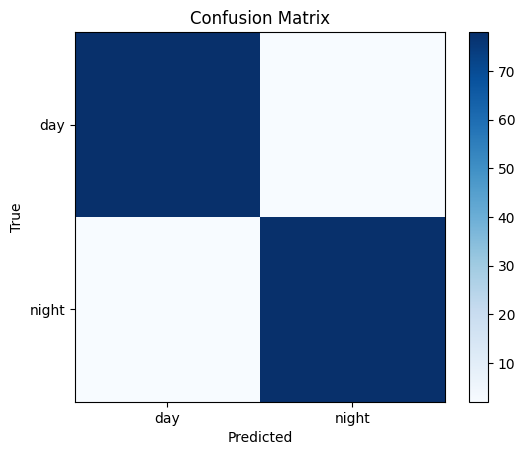

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y_pred = grid.predict(X_test_scaled)
acc = accuracy_score(y_test_enc, y_pred)
print("Akurasi SVM RBF:", acc)
print("\nClassification Report:\n", classification_report(y_test_enc, y_pred, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_test_enc, y_pred)
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(ticks=[0,1], labels=le.classes_)
plt.yticks(ticks=[0,1], labels=le.classes_)
plt.colorbar()
plt.show()

Model SVM dengan kernel RBF mampu mengklasifikasikan gambar siang dan malam dengan akurasi 95,6%.
Nilai precision, recall, dan f1-score yang seimbang (sekitar 0.95–0.96) menunjukkan bahwa model mempunyai performa yang konsisten pada kedua konidisi tanpa bias (day atau night).
Dengan hyperparameter terbaik (C: 1, gamma: 0.01), model berhasil mengenali distribusi warna dengan baik untuk membedakan kondisi cahaya siang dan malam.